In [1]:
# Fill in the name of the experiment folder in logs/, .e.g 'SR1'
EXPERIMENT = "1m-launch-firefly"

Reading experiment folder...


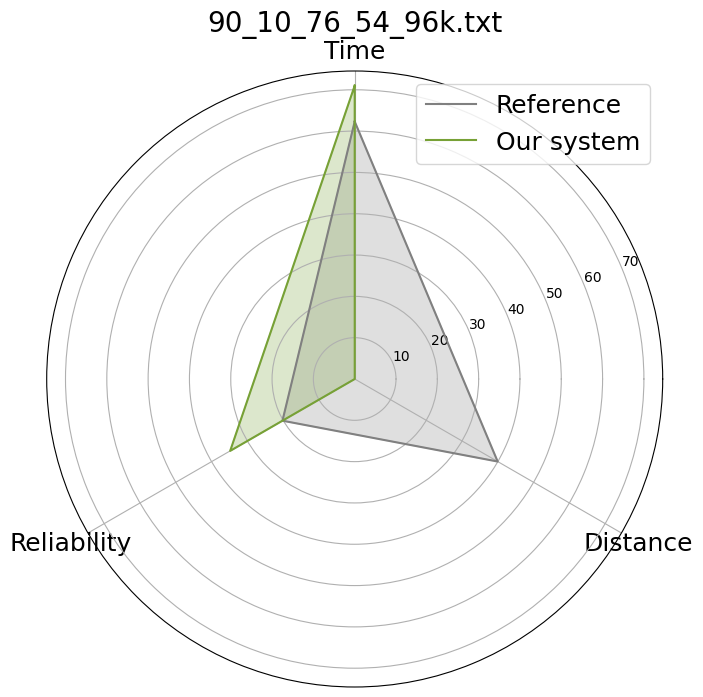

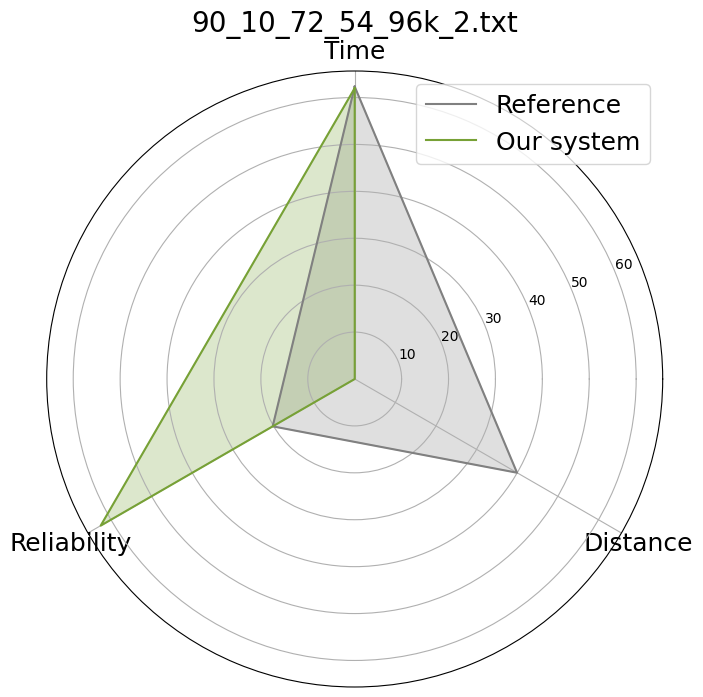

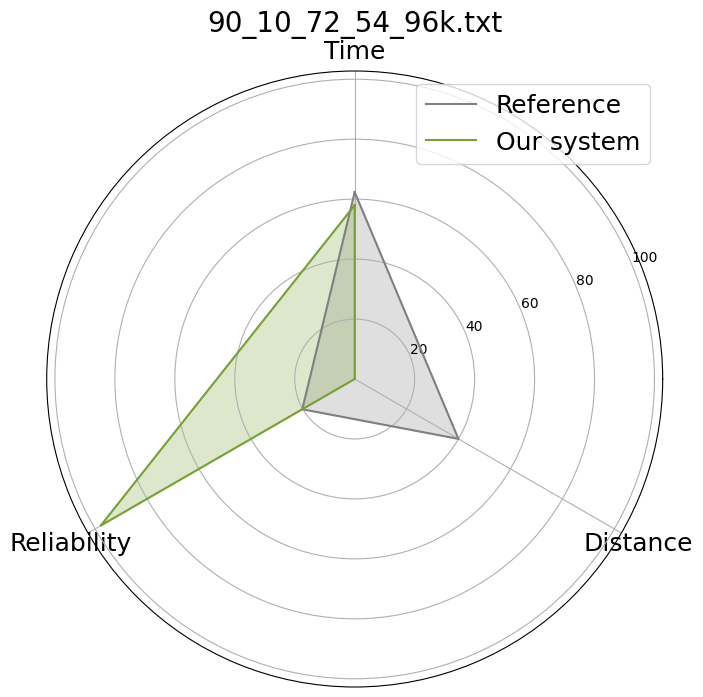

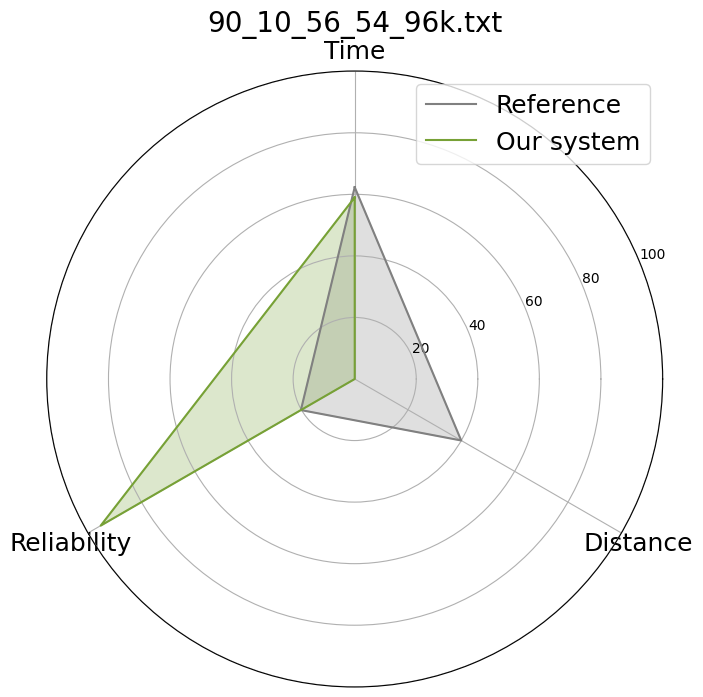

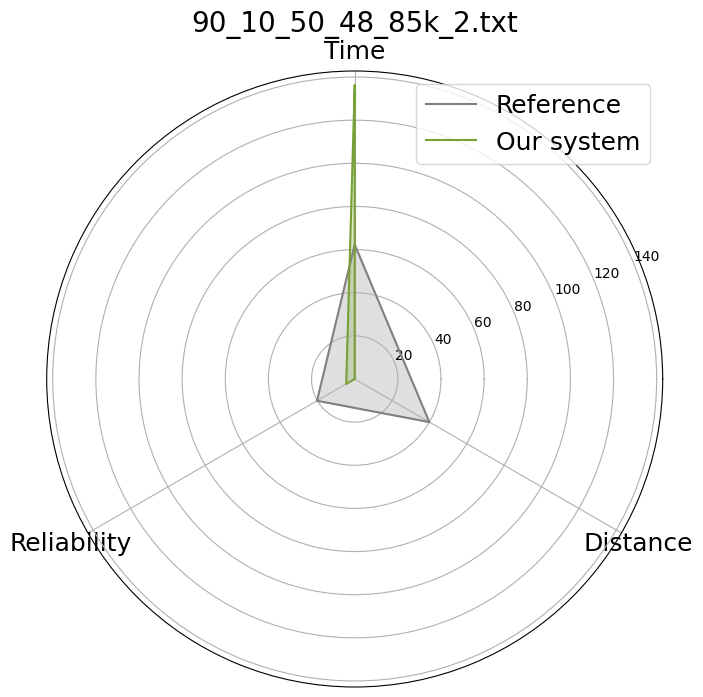

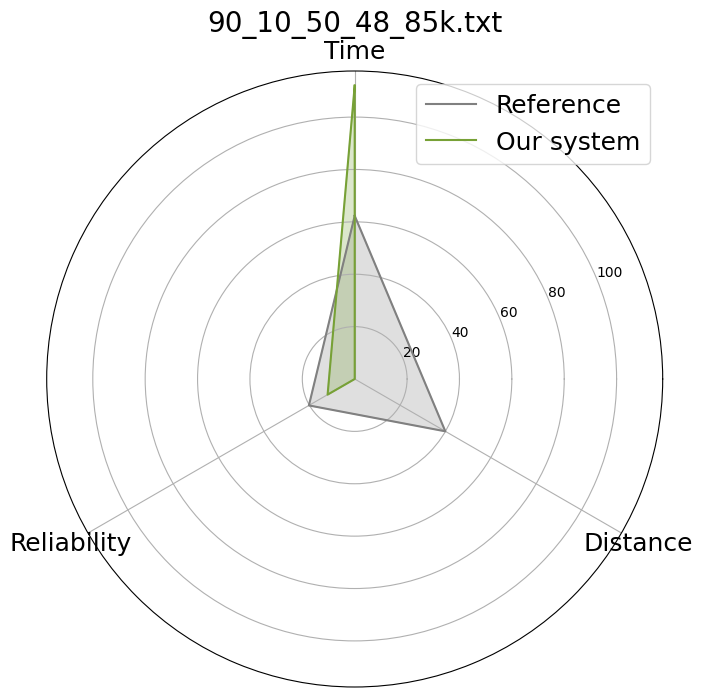

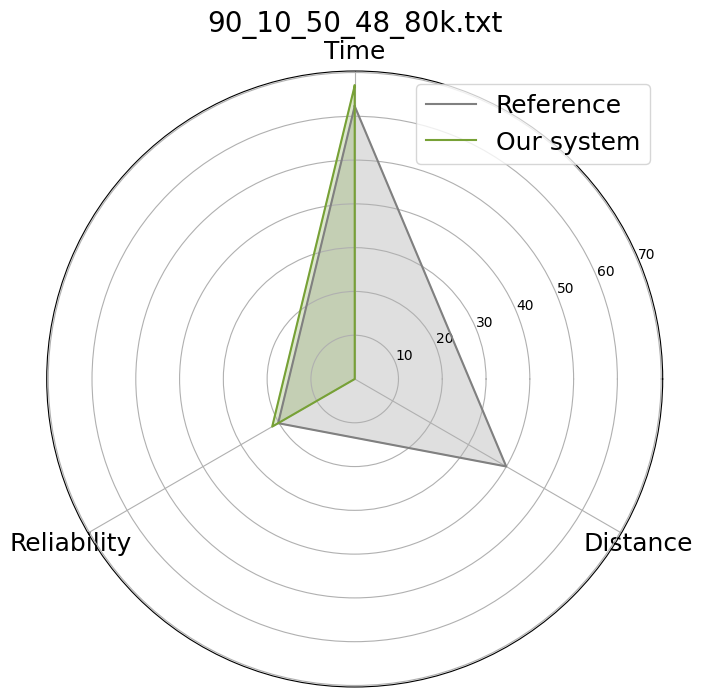

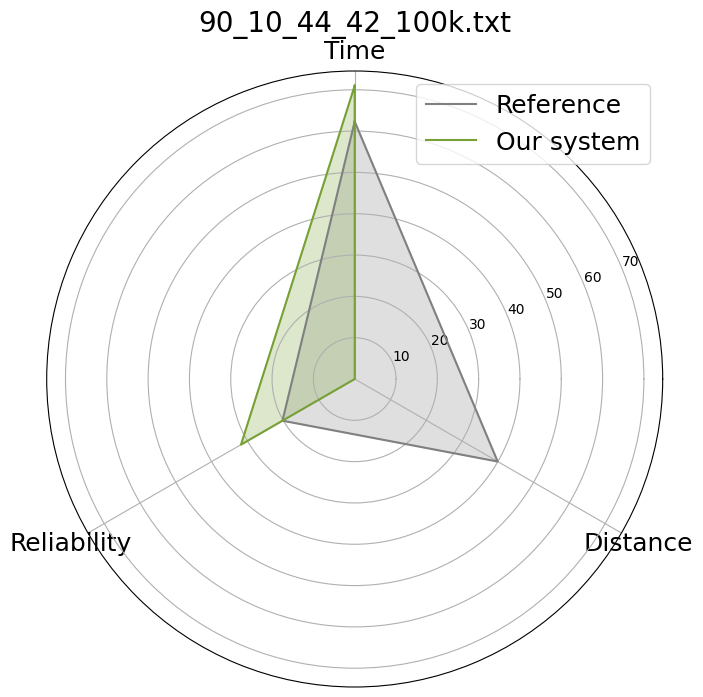

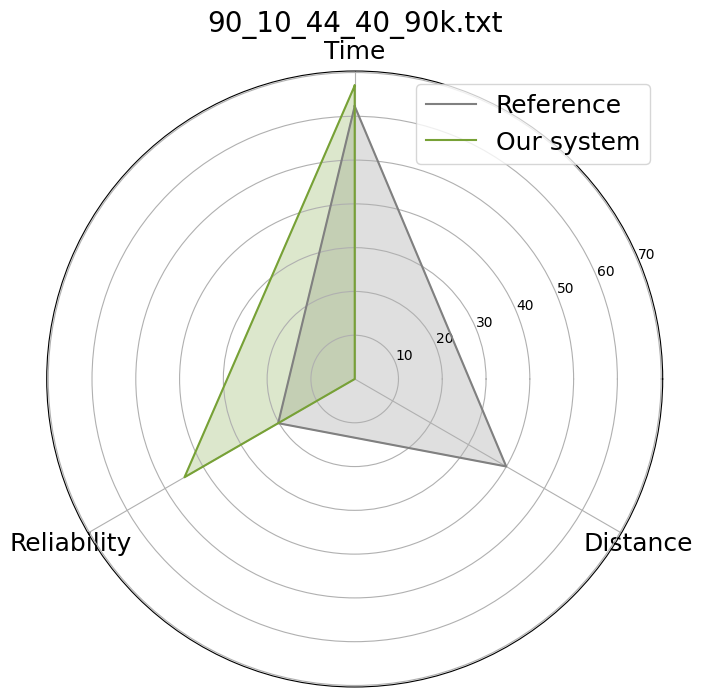

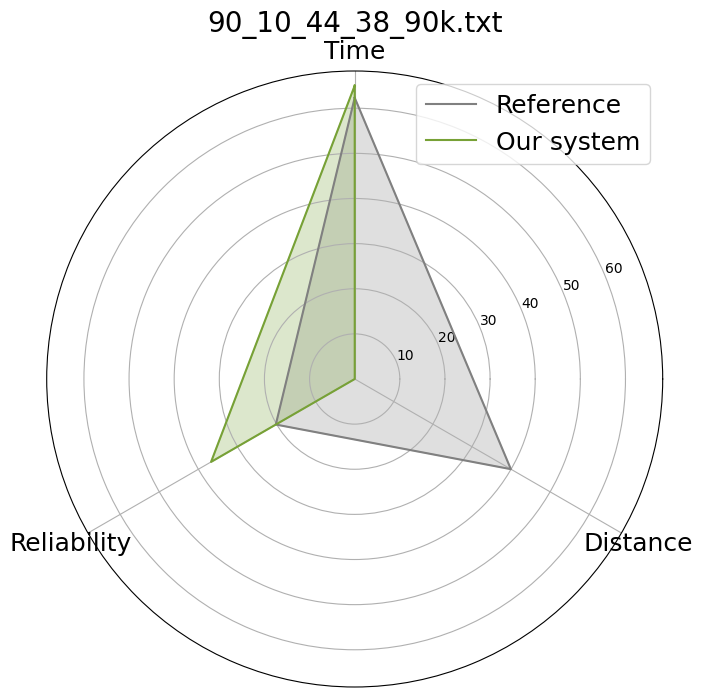

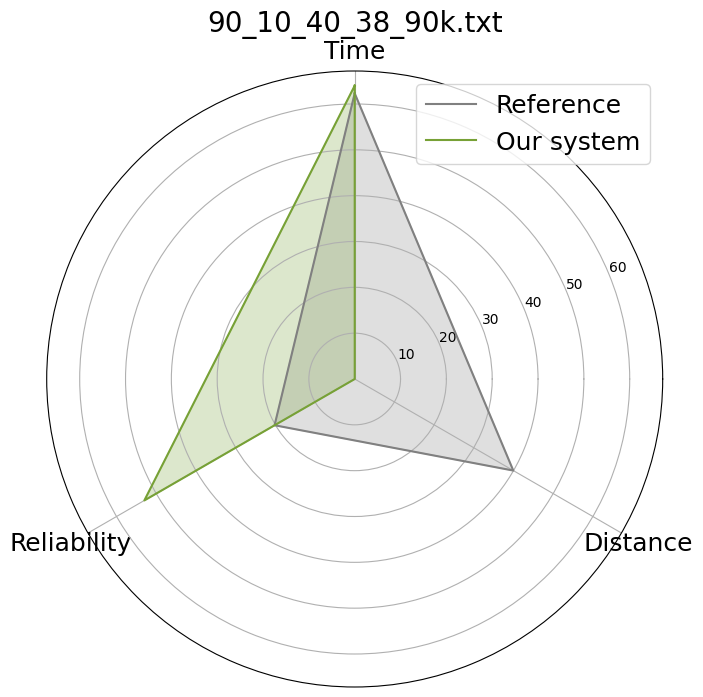

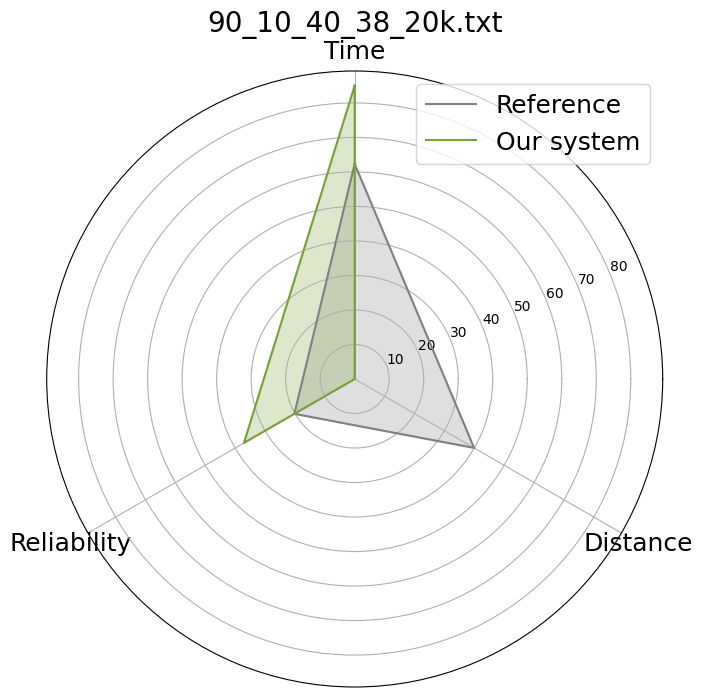

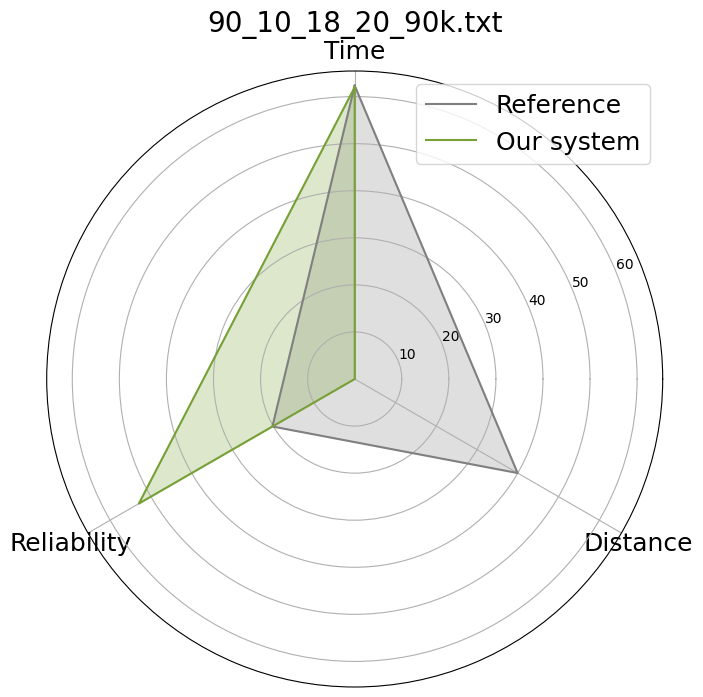

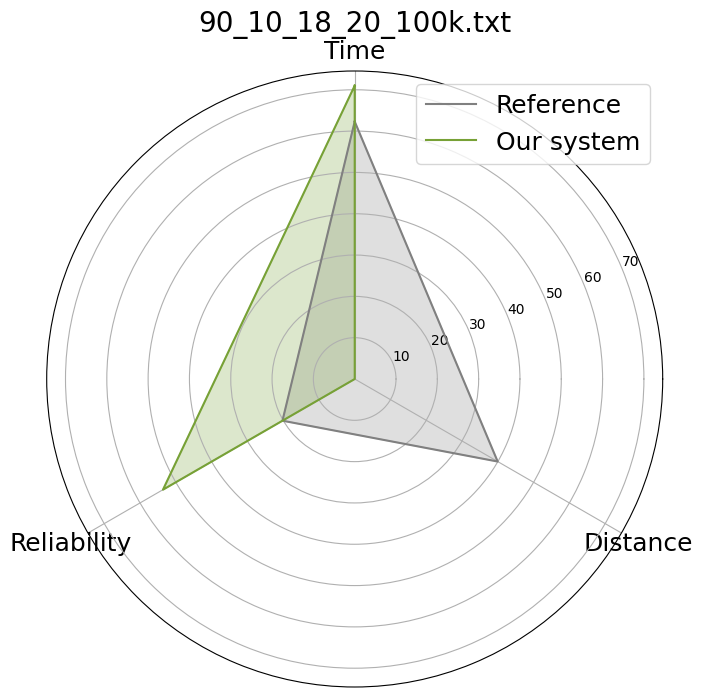

TypeError: format_exception() got an unexpected keyword argument 'etype'

In [2]:
import os
import glob
import traceback
from io import StringIO
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import NaN
from functions import * # import functions from the .py file

from pylab import rcParams
rcParams["figure.figsize"] = 16, 4

PAYLOADSIZE = 14

if PAYLOADSIZE % 2 != 0:
    print("Alarm! the payload size is not even.")
NUM_16RND = (PAYLOADSIZE-2)//2 # how many 16 bits random number included in each frame
MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq, the length of seq is 1B

clock = 125
experiments = pd.DataFrame()
experiments_df = dict()
logdir = f"./logs/{EXPERIMENT}"

print("Reading experiment folder...")
for path in glob.glob(f"{logdir}/*.txt"):
    filename = os.path.basename(path)
    params = filename.removesuffix(".txt").split("_")
    data = {
        "file": filename,
        "d2":int(params[0]), # tag to receiver (cm)
        "d1":int(params[1]), # carrier to tag (cm)
        "a": int(params[2]),
        "b": int(params[3]),
        "baud": int(params[4].replace('k', '000')),
        "delta_fsk": clock/int(params[2]) - clock/int(params[3]),
        "file_delay_s": None,
        "bit_reliability": None,
        "dis_metric": None,
        "etx": None,
        "avg_rssi": None,
        "error": False,
    }
    experiments_df[filename] = readfile(path)
    experiments = pd.concat([pd.DataFrame(data, index=[0]), experiments], ignore_index=True)

def analyze():
    errors = []
    for idx, experiment in experiments.iterrows():
        try:
            df = experiments_df[experiment["file"]]
            
            # delete the corrupted packets (PAYLOADSIZE + 2B pesudo sequence number)
            df = df[df.payload.apply(lambda x: len(x)==((PAYLOADSIZE)*3-1))]
            df.reset_index(inplace=True)
            # replace the resettable seq number to unresettable, for the purpose of reliability calculation
            test = replace_seq(df.copy(), MAX_SEQ=256)
            test.rename(columns = {'seq':'old_seq', 'new_seq':'seq'}, inplace = True)

            # compute the file delay
            file_delay = df.time_rx[len(df) - 1] - df.time_rx[0]
            # convert the timedelta to s
            file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000
            experiments.loc[idx, "file_delay_s"] = file_delay_s

            # compute the BER for all received packets
            # return the in total ber for received file, error statistics and correct file content supposed to be transmitted
            ber, error, file_content, etx = compute_ber(test, PACKET_LEN=NUM_16RND*2, MAX_SEQ=MAX_SEQ)
            bit_reliability = (1-ber)*100
            experiments.loc[idx, "etx"] = etx
            experiments.loc[idx, "bit_reliability"] = bit_reliability

            # record the distance
            dis_carrier_tag = experiment["d1"]/100 # cm -> m
            dis_tag_rx = experiment["d2"]/100 # cm -> m

            dis_metric = dis_carrier_tag**2*dis_tag_rx**2
            experiments.loc[idx, "dis_metric"] = dis_metric

            rssi = sum([x for x in df['rssi']])/len(df)
            experiments.loc[idx, "avg_rssi"] = rssi

            metrics = [file_delay_s, bit_reliability, dis_metric]
            radar_plot(metrics, title=experiment["file"])
        except Exception as e:
            experiments.loc[idx, "error"] = True
            errors.append((experiment["file"], "".join(traceback.format_exception(type(e), e, e.__traceback__))))
        
    if len(errors) > 0:
        print(f"{len(errors)} out of {len(experiments)} failed:")
        for (file, error) in errors:
            print(f"{file}:\n{error}")
        print("")

    # TODO: Only include interesting columns
    filepath = Path(f"./results/{EXPERIMENT}.csv")  
    print(f"Saving experiment data to {str(filepath)}...")
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    experiments.to_csv(filepath, index=False)
    print("Successfully saved.")
        
if experiments.size > 0:
    analyze()
else:
    print(f"No log files found in '{EXPERIMENT}'.")